In [ ]:
DATASET : https://www.kaggle.com/datasets/mnassrib/jena-climate

In [187]:
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

stop_word = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()
remove_tanda_baca = nltk.RegexpTokenizer(r"\w+")

def pre_process_text(text):
    text = ' '.join(remove_tanda_baca.tokenize(text))
    return stop_word.remove(stemmer.stem(text))

# Fungsi untuk mengganti nilai rating
def convert_rating(rating):
    if rating >= 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 0


df = pd.read_csv('./reviews_mandiri.csv')

rating_positif = df[df['rating'] >= 3].sample(n=20000, axis=0)
rating_negatif = df[df['rating'] < 3].sample(n=20000, axis=0)

slice_df = pd.concat([rating_positif, rating_negatif])
slice_df['is_positive'] = slice_df['rating'].apply(convert_rating)
slice_df['review'] = slice_df['review'].apply(pre_process_text)

In [188]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

attribute = slice_df['review'].values
label = slice_df['is_positive'].values

data_latih, data_test, label_latih, label_test = train_test_split(attribute,label,test_size=0.2)
tokenizer = Tokenizer(num_words=35000,oov_token='')
tokenizer.fit_on_texts(data_latih)

sekuens_latih = tokenizer.texts_to_sequences(data_latih)
sekuens_test = tokenizer.texts_to_sequences(data_test)

pad_latih = pad_sequences(sekuens_latih,padding='post',maxlen=87)
pad_test = pad_sequences(sekuens_test,padding='post',maxlen=87)

In [191]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

ACCURACY_TRESHOLD = 90e-2


class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= ACCURACY_TRESHOLD and val_accuracy > ACCURACY_TRESHOLD:
            print(
                f'\n Epoch {epoch}\n Accuracy has reach = {logs["accuracy"]*100:.2f}%/n training has been stopped.')
            self.model.stop_training = True


forward_layer = tf.keras.layers.LSTM(
    64, return_sequences=True, go_backwards=False)
backward_layer = tf.keras.layers.LSTM(
    64, return_sequences=True, go_backwards=True)

model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=18000, output_dim=1, input_length=87),
    tf.keras.layers.Bidirectional(
        forward_layer,
        merge_mode='sum',
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_base.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=70,
    restore_best_weights=True
)
training = model_base.fit(
    pad_latih,
    label_latih,
    epochs=250,
    validation_data=(pad_test, label_test),
    callbacks=[MyCallback(), early_stop_callback],
    batch_size=100
)

Epoch 1/250
320/320 [==============================] - 14s 41ms/step - loss: 2.0271 - accuracy: 0.7803 - val_loss: 0.3652 - val_accuracy: 0.8457
Epoch 2/250
320/320 [==============================] - 13s 39ms/step - loss: 0.3017 - accuracy: 0.8889 - val_loss: 0.4281 - val_accuracy: 0.8776
Epoch 3/250
320/320 [==============================] - 12s 38ms/step - loss: 0.2751 - accuracy: 0.9045 - val_loss: 0.3396 - val_accuracy: 0.8774
Epoch 4/250
320/320 [==============================] - 12s 38ms/step - loss: 0.2403 - accuracy: 0.9143 - val_loss: 0.3685 - val_accuracy: 0.8711
Epoch 5/250
320/320 [==============================] - 12s 37ms/step - loss: 0.2304 - accuracy: 0.9183 - val_loss: 0.4174 - val_accuracy: 0.8696
Epoch 6/250
320/320 [==============================] - 12s 37ms/step - loss: 0.2252 - accuracy: 0.9191 - val_loss: 0.4300 - val_accuracy: 0.8680
Epoch 7/250
320/320 [==============================] - 12s 36ms/step - loss: 0.2177 - accuracy: 0.9216 - val_loss: 0.4288 - val_ac

evaluate model
250/250 - 1s - loss: 0.4281 - accuracy: 0.8776 - 1s/epoch - 4ms/step


Text(0.5, 1.0, 'Accuracy & Val Accuracy')

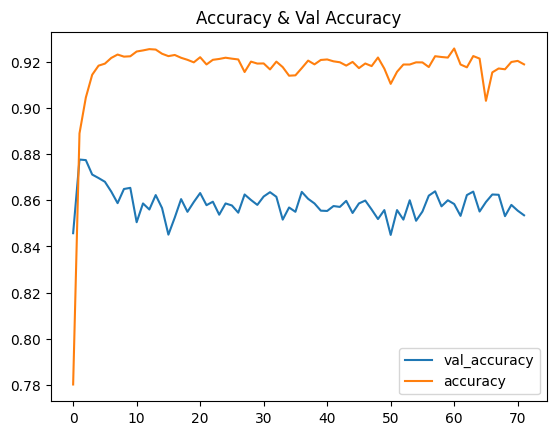

In [193]:
import matplotlib.pyplot as plt

print("evaluate model")
model_base.evaluate(pad_test,label_test,verbose=2,)

plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
# plt.plot(training.history['loss'])
plt.legend(['val_accuracy','accuracy','loss'])
plt.title('Accuracy & Val Accuracy')

In [194]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_sequence = tokenizer.texts_to_sequences(["susah transfernya"])
padded_sentence =  pad_sequences(test_sequence,padding='post',maxlen=87)

# Prediksi dengan model
predictions = model_base.predict(padded_sentence)
# Tentukan treshold untuk setiap kategori

treshold_positif = 0.7
treshold_negatif = 0.3

print('prob : ',predictions[0])

# Klasifikasikan hasil berdasarkan treshold
if predictions[0] >= treshold_positif:
    hasil_klasifikasi = "positif"
elif predictions[0] <= treshold_negatif:
    hasil_klasifikasi = "negatif"
else:
    hasil_klasifikasi = "netral"

print('Kalimat Anda diprediksi sebagai ', hasil_klasifikasi)


1/1 [==============================] - 0s 265ms/step
prob :  [0.03440987]
Kalimat Anda diprediksi sebagai  negatif


In [195]:
model_base.save('model_sigmoid.keras')